In [1]:
#Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob

In [2]:
# Find all CSV files in the working directory
csv_files = glob.glob("*.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Loop through all CSV files and read them into DataFrames
for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged.csv", index=False)

print("CSV files have been successfully merged into 'merged.csv'")

# creating a dataframe from the merged data
df = pd.read_csv('C:\\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\merged.csv', low_memory=False)

CSV files have been successfully merged into 'merged.csv'


In [3]:
#Call the info method on df to see a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295404 entries, 0 to 295403
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   points                    280922 non-null  float64
 1   Bordeaux-style Red Blend  7367 non-null    float64
 2   Cabernet Sauvignon        12821 non-null   float64
 3   Chardonnay                14502 non-null   float64
 4   Pinot Noir                14312 non-null   float64
 5   Red Blend                 10083 non-null   float64
 6   Unnamed: 0                295383 non-null  float64
 7   country                   280833 non-null  object 
 8   description               280901 non-null  object 
 9   designation               197701 non-null  object 
 10  price                     258210 non-null  float64
 11  province                  280833 non-null  object 
 12  region_1                  234594 non-null  object 
 13  region_2                  111464 non-null  o

In [4]:
#Call the head method on df to print the first several rows of the data
df.head()

,points,Bordeaux-style Red Blend,Cabernet Sauvignon,Chardonnay,Pinot Noir,Red Blend,Unnamed: 0,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,80.0,5.0,87.0,68.0,36.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,81.0,18.0,159.0,150.0,83.0,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82.0,72.0,435.0,517.0,295.0,223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83.0,95.0,570.0,669.0,346.0,364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.0,268.0,923.0,1146.0,733.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#df as well as the percentages (using `.mean()` instead of `.sum()`).
#Order them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Unnamed: 0,21,0.007109
points,14482,4.902439
description,14503,4.909548
winery,14503,4.909548
variety,14504,4.909886
country,14571,4.932567
province,14571,4.932567
price,37194,12.590892
region_1,60810,20.585368
designation,97703,33.074366


There are a number of columns here that are missing a significant amount (> 50%) of data, specifically the title (which is the name and vintage of the wine), region_2 (a secondary designetion of the region where the wine was produced), taster_name (the persone who did the review) and taster_twitter_handle. The designation is also missing nearly 30% of its values, and region_1 is missing more than 16%. The price column, which is critical to answering the business question, is missing roughly 8% of its data. A determination will need to be made, in line with the business problem, if these columns can or should be dropped.

In [6]:
#Let's see if all the entries are unique or if there might be duplicates. We'll use the description 
#label to make that determiniation.
df['description'].value_counts().head()

A little bit funky and unsettled when you pop the screwcap, but soon it finds its floral, blueberry base. Remains superficial and sweet in the mouth, with candied flavors, vanilla and mild oak. Highly regular; could use more concentration and density.    7
A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.              6
This is very light, in both flavor and body. The aromas are earthy, with a faint suggestion of blackberries, and the mouthfeel is thin. These aren't terrible flaws, but the wine just lacks substance.                                                        6
92-94 Barrel sample. A rounded wine, its tannins submerged into the ripe fruits. It feels soft, and there is just a bite of alcohol. The structure is soft, generous, opulent.                                                       

It appears that there are many duplicate rows to contend with.

In [7]:
#Are there still duplicates if we take the price column into account?
df1 =  df.astype({'price':'str'})
(df1['price'] + ', ' + df['description']).value_counts().head()

40.0, A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.                                                                                                                       6
nan, A fine and impressively complex wine, rich, packed with sultanas and dark chocolate. Very firm, this is worth aging but drinkable now.                                                                                                                                                                                                                                   6
70.0, Possibly just in a sullen phase, this reserve bottling from Craggy's home vineyard is dominated for the moment by smoke and cedar on the nose, and while there is some cherry fruit apparent in the mouth, it doesn't appear to be fully expressing itself. The im

Yes, still many duplicates.

In [8]:
#Because the varietal determines if we are talking about red, white, or dessert wines we need to see 
#the breakdown of varieties.
df['variety'].value_counts()

Pinot Noir                  27563
Chardonnay                  26235
Cabernet Sauvignon          22272
Red Blend                   19008
Bordeaux-style Red Blend    14262
                            ...  
Kotsifali                       1
Petit Courbu                    1
Misket                          1
Babosa Negro                    1
Carnelian                       1
Name: variety, Length: 756, dtype: int64

The data looks to be overwhelmingly red varietals.

In [9]:
#How many different varietals are we actually dealing with?
df['variety'].nunique()

756

In [10]:
#It's also worth looking at the statistics for the points column.

df['points'].describe()

count    280922.000000
mean         88.147073
std           3.151886
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [11]:
# Group by 'points' and calculate the count
grouped = df.groupby('points').size().reset_index(name='count')

# Calculate the total number of rows
total_rows = len(df)

# Calculate the percentage of total for each unique value
grouped['%'] = (grouped['count'] / total_rows) * 100

# Sort by 'count' in descending order
grouped = grouped.sort_values(by='count', ascending=False)

# Reset the index and drop the old index
grouped.reset_index(drop=True, inplace=True)

print(grouped)

    points  count          %
0     87.0  37681  12.755751
1     88.0  35079  11.874924
2     90.0  31384  10.624094
3     86.0  28174   9.537447
4     89.0  25148   8.513087
5     85.0  21942   7.427794
6     91.0  21896   7.412222
7     92.0  18855   6.382784
8     84.0  17189   5.818811
9     93.0  12507   4.233863
10    83.0   9074   3.071726
11    94.0   7221   2.444449
12    82.0   5878   1.989817
13    95.0   3252   1.100865
14    81.0   2195   0.743050
15    80.0   1296   0.438721
16    96.0   1219   0.412655
17    97.0    595   0.201419
18    98.0    209   0.070751
19    99.0     84   0.028436
20   100.0     44   0.014895


The most common score given to a wine is 87, followed by 88 and then 90. Given that the mean and median are each 88 this makes sense. It also makes sense to see the five lowest distributions are for the top scores of 96 through 100. Also unsurprising is that the lowest scores of 80 and 81 have relatively few entries. We can also look at this visually to get a better understanding.

<Axes: >

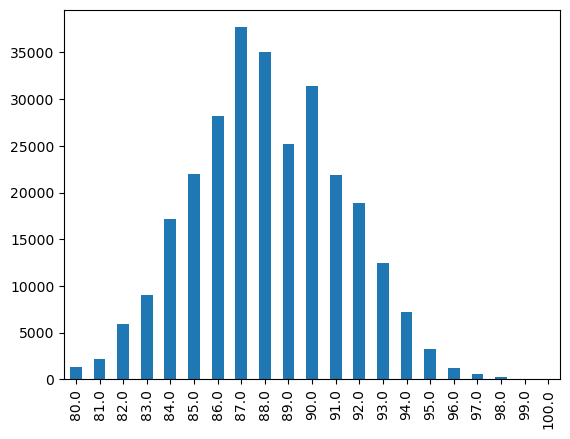

In [12]:
df['points'].value_counts().sort_index().plot.bar()

<Axes: xlabel='points'>

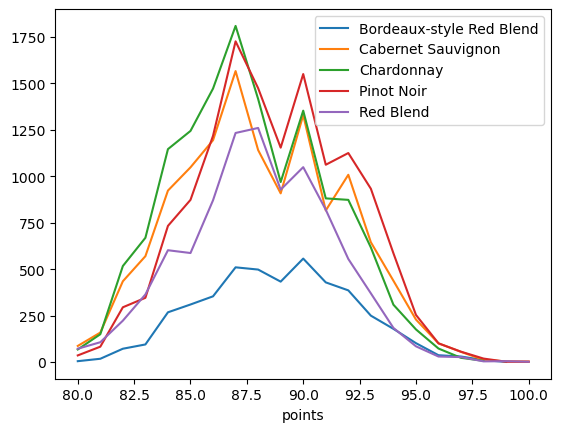

In [13]:
#A visual representation of the points by varietal might be helpful.
#Load a supplemental dataset containing the top five varietals. wine_counts counts the number of times 
#each of the possible review scores was received by the five most commonly reviewed types of wines.
wine_counts = pd.read_csv(r"C:\\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\top-five-wine-score-counts.csv", index_col=0)

#Plot the number of times a given number of points was awarded to each varietal.
wine_counts.plot.line()

The above chart shows us the most common scores for each varietal, which varietal has the most of a specific score (for example Chardonnay has the most 87s, but Pinot Noir has the most 90s. The lines also show that the scores fall into a roughly normal distribution.

In [14]:
#What about the price data? Let's look at the statistics around that column.

df['price'].describe()

count    258210.000000
mean         34.177162
std          38.611708
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

It appears there is a large variation in price, from a minimum of 4 dollars to a maximum of 3300 dollars. It might also be worth noting that the mean is closer to the 75th quartile than the 50th quartile (median). We can look at the data visually as a histogram.

<Axes: ylabel='Frequency'>

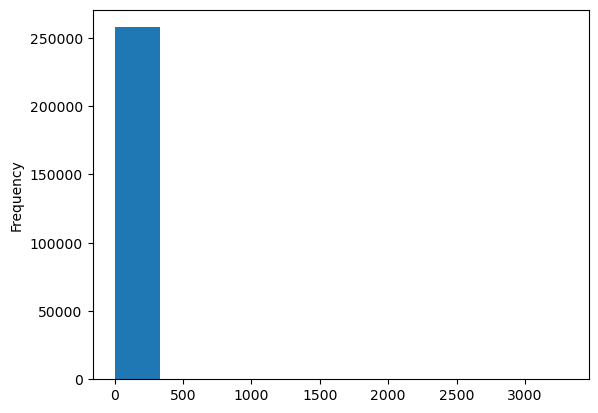

In [15]:
df['price'].plot.hist()

Because there are a number of outliers with very high prices this histogram is skewed. What if we limit the plot to bottles of wine under 100 dollars?

<Axes: ylabel='Frequency'>

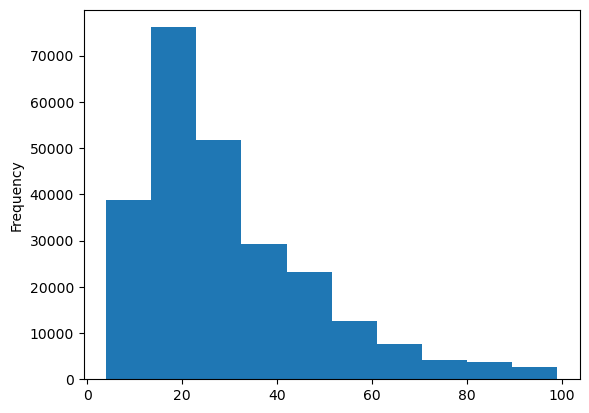

In [16]:
df[df['price'] < 100]['price'].plot.hist()

That looks better. It appears that 

Let's look at some comparisons between the price and varietal type.

Now let's look at some possible correlations between the price and the points.

<Axes: xlabel='price', ylabel='points'>

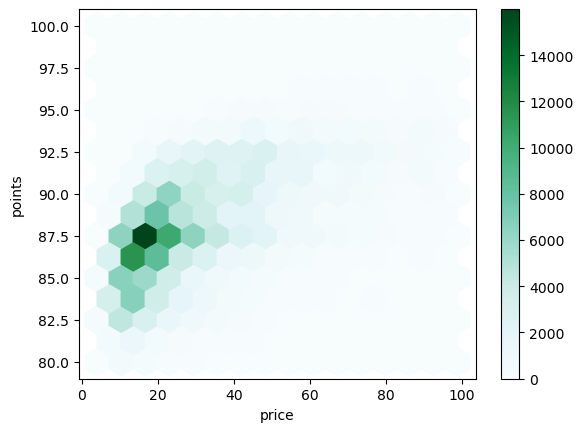

In [17]:
df[df['price'] < 100].plot.hexbin(x='price', y='points', gridsize=15)

We can see from this hexplot that the reviewed bottles of wine cluster around 87.5 points and around 20 dollars.